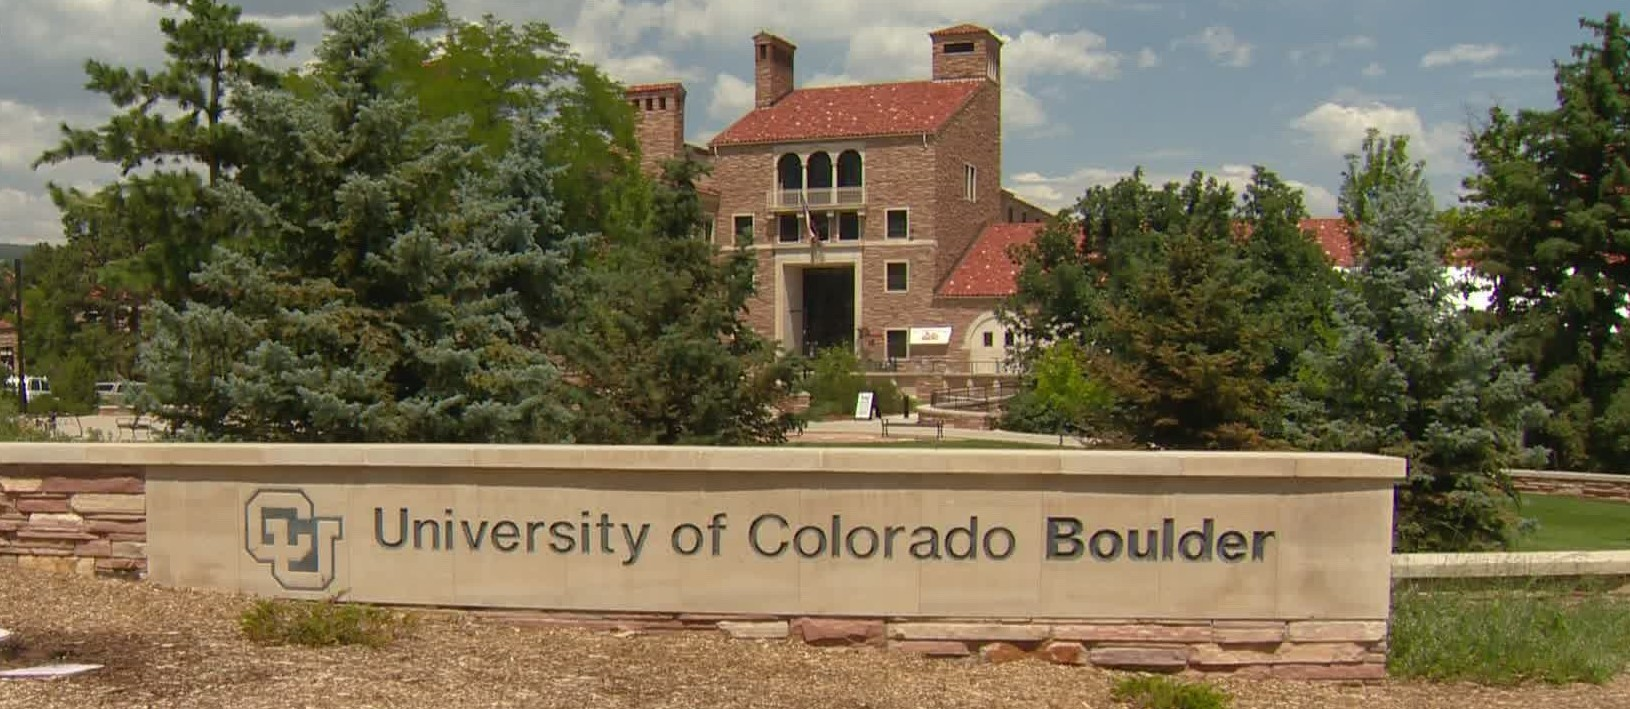

# Topic

This jupyter notebook is the final project of the University of Colorado Boulder Master of Science in Data Science courese DTSA-5509 - Introduction to Machine Learning Supervised Learning

In this notebook I mainly tried to use technics which where part of the course, namely random forrest and support vector maschines. I tried to dive a little deeper in specificly theses two types for multi class classification problems. My interrest was also to compare accuracy and computational performance and how well they performe on bigger datasets.

Finally I also made an attemd with a deep neural network based on tensorflow keras on teh same problem.

As problem and data I choose the Kaggle February 2022 Tabular Playground Series competition. The task is to classify 10 different bacteria species using data from a genomic analysis technique. The source data is the frequency of the base DNA Blocks A (Adenosine), G (Guanine), C (Cytosine) and T (Thymidine). So the full sequence is not knows and the model has to work with some lossy data to predict the correct bacteria.

## Data
The idea behind the problem as well as the data is based on Ryan L. Wood, Tanner Jensen, Cindi Wadsworth, Mark Clement, Prashant Nagpal and William G. Pitts paper "[Analysis of Identification Method for Bacterial Species and Antibiotic Resistance Genes Using Optical Data From DNA Oligomers](https://www.frontiersin.org/articles/10.3389/fmicb.2020.00257/full)".

Into the data where simulated measurement errors added by the kaggle team to make the problem  more chalanging.

The final test and train data could be found at [Kaggle competition page](https://www.kaggle.com/c/tabular-playground-series-feb-2022/data)

## Importing libraries

In [1]:
import pandas as pd
import numpy as np

# for performace patch
#from sklearnex import patch_sklearn
##patch_sklearn() # withe larger no of trees kernel dies
 
# disable  patching
#from sklearnex import unpatch_sklearn
#unpatch_sklearn()

import matplotlib.pyplot as plt
import matplotlib.image as mpimg # for image processing

from PIL import Image # new version for open image

import seaborn as sns
from IPython.display import clear_output
from scipy.stats import mode

import warnings
warnings.filterwarnings('ignore')

from time import time

from sklearn import metrics
from sklearn.metrics import confusion_matrix

from sklearn.preprocessing import LabelEncoder # To encode string labels into numeric values
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestClassifier # Load random forest classifier 

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

import joblib # For saving the trained model
import tensorflow as tf
import os

## Importing data, cleaning and analysis

### Import data and get first overview

I downloaded the data locally and saved it into my workdir of the project. Train and testset together has alsmost size of 2 Gigabyte. So be aware if you download and run the models.

In [2]:
path = "./histopathologic-cancer-detection/"
train = "train_labels.csv"
sample = "sample_submission.csv"

In [3]:
df_train = pd.read_csv(path+train)#, index_col='id')
#df_test  = pd.read_csv('test.csv', index_col='row_id')
df_subm = pd.read_csv(path+sample)

In [4]:
# take only 1000 examples for test
#df_train = df_train.iloc[10000:20000]

In [5]:
df_train_row_count, df_train_column_count=df_train.shape
print('Total number of rows:', df_train_row_count)
print('Total number of columns:', df_train_column_count)

Total number of rows: 220025
Total number of columns: 2


In [6]:
df_subm_row_count, df_subm_column_count=df_subm.shape
print('Total number of rows:', df_subm_row_count)
print('Total number of columns:', df_subm_column_count)

Total number of rows: 57458
Total number of columns: 2


In [7]:
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [8]:
df_subm.head()

,id,label
0,0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
1,95596b92e5066c5c52466c90b69ff089b39f2737,0
2,248e6738860e2ebcf6258cdc1f32f299e0c76914,0
3,2c35657e312966e9294eac6841726ff3a748febf,0
4,145782eb7caa1c516acbe2eda34d9a3f31c41fd6,0


(96, 96, 3) uint8


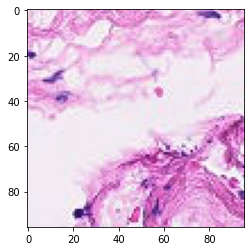

In [9]:
# Read an Images
img = mpimg.imread(path+"train/"+df_train.iloc[42].id+".tif")
#img = Image.open(path+"train/"+df_train.iloc[42].id+".tif")
#img.load()
#img = cv2.imread('boulder.jpg')
 
# Output Images
plt.imshow(img)

#lets check shape and datatype of image
print(img.shape, img.dtype)

(32, 32, 3) uint8


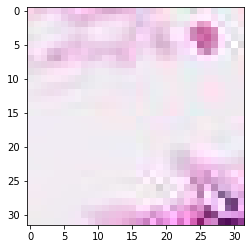

In [10]:
# According to dataset description only ceter 32x32 areas is relevant for analysis, therefore crop image
taget_size = 32
# crop image
# take center and substract/add 0,5 taget size
img = img[int(img.shape[0]/2-taget_size/2):int(img.shape[0]/2+taget_size/2),
                  int(img.shape[1]/2-taget_size/2):int(img.shape[1]/2+taget_size/2),
                  :]

# Output Images
plt.imshow(img)

# lets check shape and datatype of image
print(img.shape, img.dtype)

# this also makes sure all imagages have same size

(32, 32, 3) float32


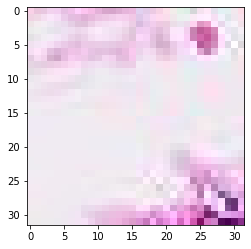

In [11]:
# Convert to float type
img = np.float32(img)

# normalise image
img = (img - np.min(img)) / (np.max(img) - np.min(img))

# Output Images
plt.imshow(img)

# lets check shape and datatype of image
print(img.shape, img.dtype)

In [12]:
# Reshape the image for further processing
# img2d = img.reshape((-1,3))
 
# # Convert to float type
# img2d = np.float32(img2d)
#min(df_train.index)

In [13]:
# define function for image processing

def img_processing(name, taget_size):
    # Read an Images
    img = mpimg.imread(name)

    # crop image
    # take center and substract/add 0,5 taget size
    img = img[int(img.shape[0]/2-taget_size/2):int(img.shape[0]/2+taget_size/2),
                      int(img.shape[1]/2-taget_size/2):int(img.shape[1]/2+taget_size/2),
                      :]
    # Convert to float type
#    img = np.float32(img)

    # normalise image
#    img = (img - np.min(img)) / (np.max(img) - np.min(img))
    return img #.reshape((-1,3))

In [14]:
# create array for images
imgs = np.zeros([df_train_row_count, 32, 32, 3])
#imgs = np.zeros([max(df_train.index), 32, 32, 3])

# now try to import all training images:
for index, row in df_train.iterrows():
    imgs[index] = img_processing(name=path+"train/"+row.id+".tif", taget_size=32)

In [30]:
# Safe array with images to file
np.save("imgs", imgs)

In [14]:
# Load array with images from file
imgs = np.load("imgs.npy")

In [15]:
imgs.shape

(220025, 32, 32, 3)

In [16]:
df_train_row_count

220025

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


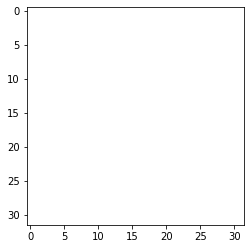

In [17]:
plt.imshow(imgs[42])

In [18]:
target_class = pd.DataFrame({'count': df_train.label.value_counts(),
                             'percentage': df_train['label'].value_counts() / df_train.shape[0] * 100
})
target_class

,count,percentage
0,130908,59.496875
1,89117,40.503125


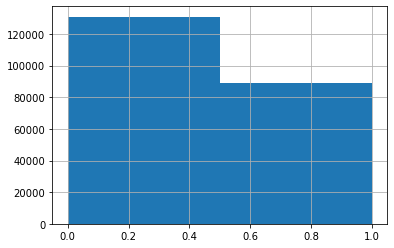

In [19]:
# increase size of plots
#plt.rcParams["figure.figsize"] = (20,10)

# create a histogramm
plt.hist(df_train.label, density=False, bins=2) #, orientation='horizontal')
plt.grid(True)
plt.show()


# # to visulize the difference better use also a log scale
# plt.hist(df_train.target, density=True, orientation='horizontal', log=True)
# plt.grid(True)
# plt.show()

Source data consits of of three files

- train.csv
- test.csv
- sample_submission.csv

Train data contains 200000 rows and 287 columns. 286 feature coloumns with the frequence of the possible DNA messurements as float and one column "target" with the ground truth of the bactery name as string.

The possible 10 bacterias are:

- Bacteroides_fragilis 	
- Streptococcus_pyogenes 	
- Streptococcus_pneumoniae 	
- Campylobacter_jejuni 	
- Salmonella_enterica 	
- Escherichia_coli
- Enterococcus_hirae
- Escherichia_fergusonii 	
- Staphylococcus_aureus 	
- Klebsiella_pneumoniae

and the frequency is alsmost equal distributed between 9.9% and 10.1%.

There are some correleted features and some pattern within the correlation heatmap are visible.

Test data contains 100000 rows and 286 columns. It alsco contains the 286 features but no targed value.

sample_submission is just a sample file how the Kaggle submission should look like and consits of 100000 rows and 2 columns, one with the ID and and one for the predicted bacteria.

### Further analysis and cleaning

### Check for duplicate entries

In [20]:
# check for duplicate entries
print("duplicate entries in trainset:",df_train.duplicated().sum())
#print("duplicate entries in testset:",df_test.duplicated().sum())
# u, c = np.unique(imgs, return_counts=True)
# dup = u[c > 1]


duplicate entries in trainset: 0


After data cleaning we are left with 123993 unique rows in testset with one taget value and 286 features. We have no NA or missing values.

### Create dataframes for ground truth (y) and features (X)

In [21]:
# Reshape the images.
#imgs = np.expand_dims(imgs, axis=4)
#imgs = imgs.reshape((-1,3))
#test_images = np.expand_dims(test_images, axis=3)

In [22]:
imgs.shape

(220025, 32, 32, 3)

In [23]:
#Defining X and y
#X = df_train.drop(['target'], axis=1)
X = imgs
y = df_train['label']


### Split dataset for training and internal testing

In [24]:
# creating dataset split for prediction
from sklearn.model_selection import train_test_split
X_train, X_test , y_train , y_test = train_test_split(X,y,test_size=0.2,random_state=42) # 80-20 split

# Checking split 
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

X_train: (176020, 32, 32, 3)
y_train: (176020,)
X_test: (44005, 32, 32, 3)
y_test: (44005,)


In [25]:
#Print Confusion Matrix
# print("Random Forrest Accuracy:",metrics.accuracy_score(y_test, y_pred))
# cm = pd.DataFrame(confusion_matrix(y_test, y_pred))
# sns.heatmap(cm, annot=True)
#X.dtype
y.dtype
X_train.shape[2]


32

In this case we have accuracy of 1 on the tetset and therefore also in confusion matrix just machees in the diagonal. For the real testset on Kaggle I dont have the ground truth and therefore no cofusion matrix. But also there the accuracy is above 0.97.

## Deep neural network

As last technics I tried to create deep neural network with tensorflow and a sequencial keras model. Here I experimented a lot with different layers, number of neurons, regularisations and dropouts.

Also it took some time until training performance was good and tensorflow was working with my grafics card.

Below is the final model I used. We have some dense layers with decreasing number of neurons. Some use L2 regularisations and some are followed by dropout layers to make model more robust and prevent from overfitting.

Las layer use a softmax activation to create the predictions for our 10 classes (bacterias).

In [26]:
# Create tensorflow Model
tf.keras.regularizers.l2(l2=0.0001)
#tf.keras.regularizers.l1

model = tf.keras.models.Sequential([
  tf.keras.layers.Normalization(axis=-1),
      tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 3)),
  tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
  #tf.keras.layers.Conv2D(filters = 32, kernel_size = 3, activation='relu', input_shape=(taget_size, taget_size, 3)),
  tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='relu'),
    tf.keras.layers.Conv2D(filters = 64, kernel_size = 3, activation='relu'),
#  tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, input_shape=(taget_size, taget_size, 3)),
     tf.keras.layers.Dropout(0.3),
    tf.keras.layers.MaxPooling2D(pool_size = 2),
     tf.keras.layers.Conv2D(filters = 128, kernel_size = 3, activation='relu'),
#     tf.keras.layers.Conv2D(filters = 128, kernel_size = 3),#, activation='relu'),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.MaxPooling2D(pool_size = 2),
#    tf.keras.layers.Conv2D(filters = 256, kernel_size = 3),#, activation='relu'),
#    tf.keras.layers.MaxPooling2D(pool_size = 2),
#    tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(2, activation='softmax'),
 #   tf.keras.layers.Dense(2, activation='sigmoid'),
    
    
])

model.compile(optimizer='adam',
#              loss='sparse_categorical_crossentropy',
              loss='CategoricalCrossentropy',
            #  loss='mean_squared_error',
              
#              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [27]:
# fit Model on testdata Could also be used to continue training

model.fit(X_train,
          tf.keras.utils.to_categorical(y_train),
          epochs=10,
#          batch_size=32,
          batch_size=128,
          validation_data=(X_test, tf.keras.utils.to_categorical(y_test))
         )


Epoch 1/10
1376/1376 [==============================] - 20s 13ms/step - loss: 0.6356 - accuracy: 0.7419 - val_loss: 0.5053 - val_accuracy: 0.7601
Epoch 2/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.4903 - accuracy: 0.7701 - val_loss: 0.4921 - val_accuracy: 0.7689
Epoch 3/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.4771 - accuracy: 0.7781 - val_loss: 0.4704 - val_accuracy: 0.7940
Epoch 4/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.4574 - accuracy: 0.7919 - val_loss: 0.4271 - val_accuracy: 0.8122
Epoch 5/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.4420 - accuracy: 0.8020 - val_loss: 0.4134 - val_accuracy: 0.8207
Epoch 6/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.4266 - accuracy: 0.8105 - val_loss: 0.4133 - val_accuracy: 0.8193
Epoch 7/10
1376/1376 [==============================] - 18s 13ms/step - loss: 0.4158 - accuracy: 0.8157 - val_loss: 0.4223 -

In [28]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 64)        3

Via history the performed training losses (and therewith also the epochs) could be accessed

In [29]:
training_loss = list(model.history.history['loss'])
val_loss = list(model.history.history['val_loss'])
training_acc = list(model.history.history['accuracy'])
val_acc = list(model.history.history['val_accuracy'])
epochs = len(training_loss)

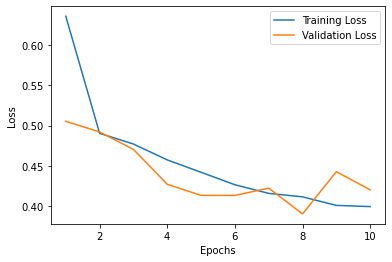

In [30]:
plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.plot(list(range(1,epochs+1,1)), val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


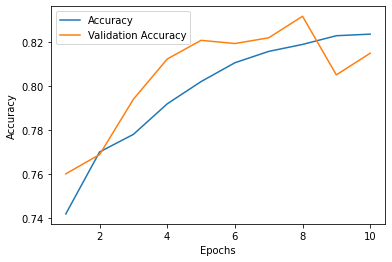

In [31]:
plt.plot(list(range(1,epochs+1,1)), training_acc, label='Accuracy')
plt.plot(list(range(1,epochs+1,1)), val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

With this data also the trainign could be continued and a pretrained model coudl get further training.

In [ ]:
# continue trainging
additional_epochs = 40

model.fit(X_train,
          tf.keras.utils.to_categorical(y_train),
          epochs=epochs+additional_epochs,
          initial_epoch=epochs,
          batch_size=128,
          validation_data=(X_test, tf.keras.utils.to_categorical(y_test))
         )

Epoch 11/50
1376/1376 [==============================] - 18s 13ms/step - loss: 0.3967 - accuracy: 0.8265 - val_loss: 0.4059 - val_accuracy: 0.8231
Epoch 12/50
1376/1376 [==============================] - 18s 13ms/step - loss: 0.3920 - accuracy: 0.8278 - val_loss: 0.3945 - val_accuracy: 0.8252
Epoch 13/50
1376/1376 [==============================] - 19s 13ms/step - loss: 0.3913 - accuracy: 0.8277 - val_loss: 0.4056 - val_accuracy: 0.8210
Epoch 14/50
1376/1376 [==============================] - 21s 16ms/step - loss: 0.3872 - accuracy: 0.8301 - val_loss: 0.3997 - val_accuracy: 0.8304
Epoch 15/50
1118/1376 [=======================>......] - ETA: 3s - loss: 0.3835 - accuracy: 0.8315

In [54]:
training_loss.extend(list(model.history.history['loss']))
val_loss.extend(list(model.history.history['val_loss']))
training_acc.extend(list(model.history.history['accuracy']))
val_acc.extend(list(model.history.history['val_accuracy']))
epochs = len(training_loss)

To check how the training proceed I plotted regular the loss agaist the number of epochs.

First Successful attempt:

In [53]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 16)        448       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 16)        2320      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 12, 12, 32)        4640      
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 32)        9

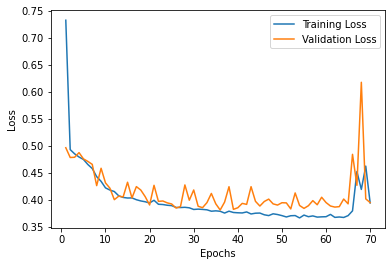

In [55]:
plt.plot(list(range(1,epochs+1,1)), training_loss, label='Training Loss')
plt.plot(list(range(1,epochs+1,1)), val_loss, label='Validation Loss')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

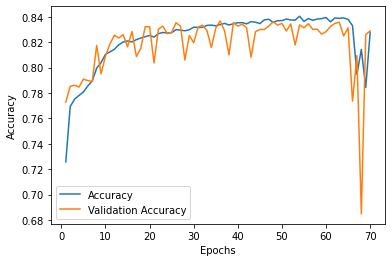

In [56]:
plt.plot(list(range(1,epochs+1,1)), training_acc, label='Accuracy')
plt.plot(list(range(1,epochs+1,1)), val_acc, label='Validation Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

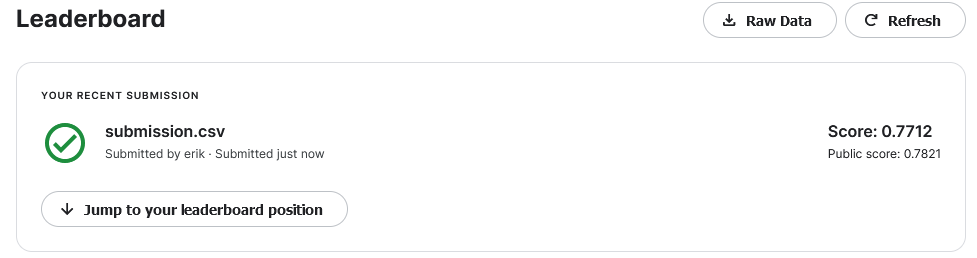

In [46]:
# Check if GPU is present and configured for tensorflow
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Evaluate model an train data
#model.evaluate(tf.convert_to_tensor(X_test.values), tf.convert_to_tensor(y_test))

#model.summary()

Num GPUs Available:  1


### Final model training on full data

Also the neural nbetwork was trained on the full dataset. In this case in total I trained it for 1500 epochs and loss was still decreasing.

In [47]:
# create array for images
imgs_submit = np.zeros([df_subm_row_count, 32, 32, 3])
#imgs = np.zeros([max(df_train.index), 32, 32, 3])

# now try to import all training images:
for index, row in df_subm.iterrows():
    imgs_submit[index] = img_processing(name=path+"test/"+row.id+".tif", taget_size=32)

In [48]:
# Safe array with images to file
np.save("imgs_submit", imgs_submit)

In [14]:
# Load array with images from file
imgs_submit = np.load("imgs_submit.npy")

In [49]:
# Make final prediction tensoflow dnn
y_submit = model.predict(imgs_submit)
    
#convert propabilities to the maximum confident value
y_submit = np.argmax(y_submit, axis=1)

## Prepare submission

In [50]:
# create dataframe
y_submit = pd.DataFrame(y_submit)

# rename columns
y_submit.columns = ["label"]

y_submit.head()

,label
0,0
1,0
2,0
3,0
4,0


In [51]:
# Create submission

# Add "row_id" from testset
submission=pd.concat([df_subm['id'],y_submit],axis=1)

# Write submission file
submission.to_csv("submission.csv",index=False)

## Conclusion

First of all I learned a lot during this project. Beside the theoretical part covered during the course espacially here the computational performance was a big issue.

The dataset as well as the models where large compared to what we did during the course and the technics to take care of these topics were verry interesting and sometimes challanging.

My goal was to dig a littee deeper in area of randmo forrest calssifiers and try hands on the one vs all classifier with SVM wich was onyl covered theoretical during course. Also I would brush up my neural network skills a bit.

At the end my first approach with the random forrest lead to the best performace on this dataset. On the real testset on Kaggle I was able to archive a accuracy of 0.97736 which brought me into top 30%.

There is still a lot of room for improvement and to push the accuracy further but I would make a intermediate break here to be able to submit the project for review.

The supremacy of random forrest over SVM was not surprising for me on such a big dataset. But I hoped to be able to outperform the random forrest with the neural network. But in this case my models where either not complex enough to beat the forrest or wherer overfitting.

More data preprocessing and/or postprocessing could probably lead to further improvements. 